In [287]:
# Basic libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np
import math

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and feature engineering libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# To split the dataset into training and testing sets
from sklearn.model_selection import train_test_split


Loading the dataset


In [288]:
df = pd.read_csv("./football.csv")
copy = df.copy()

In [289]:
df.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal


In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8925 entries, 0 to 8924
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   matchId                8925 non-null   object 
 1   playerId               8925 non-null   object 
 2   playType               8925 non-null   object 
 3   bodyPart               8925 non-null   object 
 4   x                      8925 non-null   float64
 5   y                      8925 non-null   float64
 6   interveningOpponents   8925 non-null   int64  
 7   interveningTeammates   8925 non-null   int64  
 8   interferenceOnShooter  8891 non-null   object 
 9   minute                 8925 non-null   int64  
 10  second                 8925 non-null   int64  
 11  outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 836.8+ KB


In [291]:
for col in ["playType","bodyPart","interferenceOnShooter","outcome"]:
  print('the col:',col)
  print(df[col].unique())

the col: playType
['open play' 'free kick' 'penalty' 'olimpico']
the col: bodyPart
['right foot' 'left foot' 'head' 'other']
the col: interferenceOnShooter
['medium' 'low' 'high' nan]
the col: outcome
['goal' 'saved by keeper' 'missed chance' 'blocked shot' 'hit the post'
 nan]




> deleting the duplicates and missing values



In [292]:
df.drop_duplicates(inplace=True)

In [293]:
df = df.dropna()

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8891 entries, 0 to 8924
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   matchId                8891 non-null   object 
 1   playerId               8891 non-null   object 
 2   playType               8891 non-null   object 
 3   bodyPart               8891 non-null   object 
 4   x                      8891 non-null   float64
 5   y                      8891 non-null   float64
 6   interveningOpponents   8891 non-null   int64  
 7   interveningTeammates   8891 non-null   int64  
 8   interferenceOnShooter  8891 non-null   object 
 9   minute                 8891 non-null   int64  
 10  second                 8891 non-null   int64  
 11  outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 903.0+ KB


# Data Cleaning and labeling


# first- merging the interveners:

In [295]:
df['allinterveners'] = df['interveningOpponents'] + df['interveningTeammates']

In [296]:
df

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome,allinterveners
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal,1
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper,3
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper,8
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance,5
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8920,m_57,p_115,open play,head,6.48,3.99,3,0,high,69,50,missed chance,3
8921,m_59,p_76,open play,right foot,21.45,-8.73,4,1,medium,15,53,blocked shot,5
8922,m_55,p_150,open play,left foot,11.97,3.24,3,0,medium,84,34,missed chance,3
8923,m_33,p_130,open play,right foot,6.48,-6.98,1,0,high,4,39,missed chance,1


# Cleaning the ID from characters

In [297]:
def clean_IDs(df):
    for col in ["playerId", "matchId"]:
        df[col] = df[col].apply(lambda x: int(x.split("_")[1]))
    return df

df = clean_IDs(df=df)

# evaluating distance

In [298]:
df['distance'] = (df['x']**2 + df['y']**2)**(0.5)

In [299]:
df

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome,allinterveners,distance
0,91,103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal,1,17.530810
1,17,16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper,3,17.090313
2,111,88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper,8,29.456534
3,142,87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance,5,26.948560
4,117,9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal,2,11.932141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8920,57,115,open play,head,6.48,3.99,3,0,high,69,50,missed chance,3,7.609895
8921,59,76,open play,right foot,21.45,-8.73,4,1,medium,15,53,blocked shot,5,23.158484
8922,55,150,open play,left foot,11.97,3.24,3,0,medium,84,34,missed chance,3,12.400746
8923,33,130,open play,right foot,6.48,-6.98,1,0,high,4,39,missed chance,1,9.524222


# calculating the angle


In [300]:
def rad2deg(radians):
    return radians * (180 / math.pi)

def calculate_angle(row):
    x = row['x']
    y = row['y']
    theta = (7.32 * x) / (x**2 + y**2 - (7.32/2)**2)
    if theta >= 0:
        return rad2deg(math.atan(theta))
    else:
        return rad2deg(math.atan(theta) + math.pi)

df['angle'] = df.apply(calculate_angle, axis=1)
df

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome,allinterveners,distance,angle
0,91,103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal,1,17.530810,18.544088
1,17,16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper,3,17.090313,13.982592
2,111,88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper,8,29.456534,14.153255
3,142,87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance,5,26.948560,15.458384
4,117,9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal,2,11.932141,31.315918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8920,57,115,open play,head,6.48,3.99,3,0,high,69,50,missed chance,3,7.609895,46.818116
8921,59,76,open play,right foot,21.45,-8.73,4,1,medium,15,53,blocked shot,5,23.158484,16.713121
8922,55,150,open play,left foot,11.97,3.24,3,0,medium,84,34,missed chance,3,12.400746,31.970470
8923,33,130,open play,right foot,6.48,-6.98,1,0,high,4,39,missed chance,1,9.524222,31.529506


**Set the parameter of outcome to a boolean becuase of our predicting**

In [301]:
df['outcome'] = df['outcome'] == 'goal'
df

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome,allinterveners,distance,angle
0,91,103,open play,right foot,13.47,-11.22,1,0,medium,70,9,True,1,17.530810,18.544088
1,17,16,open play,left foot,9.48,14.22,3,0,medium,55,4,False,3,17.090313,13.982592
2,111,88,free kick,left foot,29.43,-1.25,6,2,low,86,31,False,8,29.456534,14.153255
3,142,87,open play,right foot,26.93,1.00,4,1,medium,77,2,False,5,26.948560,15.458384
4,117,9,open play,right foot,10.72,5.24,2,0,medium,76,46,True,2,11.932141,31.315918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8920,57,115,open play,head,6.48,3.99,3,0,high,69,50,False,3,7.609895,46.818116
8921,59,76,open play,right foot,21.45,-8.73,4,1,medium,15,53,False,5,23.158484,16.713121
8922,55,150,open play,left foot,11.97,3.24,3,0,medium,84,34,False,3,12.400746,31.970470
8923,33,130,open play,right foot,6.48,-6.98,1,0,high,4,39,False,1,9.524222,31.529506


# Some visualizing

In [302]:
distances = df['distance'].sort_values(ascending=False)
distances.head()

7013    71.783221
4432    64.847711
6974    60.892618
3031    59.205683
1666    58.211343
Name: distance, dtype: float64

In [303]:
df

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome,allinterveners,distance,angle
0,91,103,open play,right foot,13.47,-11.22,1,0,medium,70,9,True,1,17.530810,18.544088
1,17,16,open play,left foot,9.48,14.22,3,0,medium,55,4,False,3,17.090313,13.982592
2,111,88,free kick,left foot,29.43,-1.25,6,2,low,86,31,False,8,29.456534,14.153255
3,142,87,open play,right foot,26.93,1.00,4,1,medium,77,2,False,5,26.948560,15.458384
4,117,9,open play,right foot,10.72,5.24,2,0,medium,76,46,True,2,11.932141,31.315918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8920,57,115,open play,head,6.48,3.99,3,0,high,69,50,False,3,7.609895,46.818116
8921,59,76,open play,right foot,21.45,-8.73,4,1,medium,15,53,False,5,23.158484,16.713121
8922,55,150,open play,left foot,11.97,3.24,3,0,medium,84,34,False,3,12.400746,31.970470
8923,33,130,open play,right foot,6.48,-6.98,1,0,high,4,39,False,1,9.524222,31.529506


In [304]:

df

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome,allinterveners,distance,angle
0,91,103,open play,right foot,13.47,-11.22,1,0,medium,70,9,True,1,17.530810,18.544088
1,17,16,open play,left foot,9.48,14.22,3,0,medium,55,4,False,3,17.090313,13.982592
2,111,88,free kick,left foot,29.43,-1.25,6,2,low,86,31,False,8,29.456534,14.153255
3,142,87,open play,right foot,26.93,1.00,4,1,medium,77,2,False,5,26.948560,15.458384
4,117,9,open play,right foot,10.72,5.24,2,0,medium,76,46,True,2,11.932141,31.315918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8920,57,115,open play,head,6.48,3.99,3,0,high,69,50,False,3,7.609895,46.818116
8921,59,76,open play,right foot,21.45,-8.73,4,1,medium,15,53,False,5,23.158484,16.713121
8922,55,150,open play,left foot,11.97,3.24,3,0,medium,84,34,False,3,12.400746,31.970470
8923,33,130,open play,right foot,6.48,-6.98,1,0,high,4,39,False,1,9.524222,31.529506


# Calculate mutual information

In [305]:
X = df.drop('outcome', axis=1)
y = df['outcome']
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

X

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,allinterveners,distance,angle
0,91,103,2,3,13.47,-11.22,1,0,2,70,9,1,17.530810,18.544088
1,17,16,2,1,9.48,14.22,3,0,2,55,4,3,17.090313,13.982592
2,111,88,0,1,29.43,-1.25,6,2,1,86,31,8,29.456534,14.153255
3,142,87,2,3,26.93,1.00,4,1,2,77,2,5,26.948560,15.458384
4,117,9,2,3,10.72,5.24,2,0,2,76,46,2,11.932141,31.315918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8920,57,115,2,0,6.48,3.99,3,0,0,69,50,3,7.609895,46.818116
8921,59,76,2,3,21.45,-8.73,4,1,2,15,53,5,23.158484,16.713121
8922,55,150,2,1,11.97,3.24,3,0,2,84,34,3,12.400746,31.970470
8923,33,130,2,3,6.48,-6.98,1,0,0,4,39,1,9.524222,31.529506


In [306]:
mi = mutual_info_regression(X, y)
mi /= np.max(mi)

mi_df = pd.DataFrame({'feature': X.columns, 'importance': mi})
mi_df = mi_df.sort_values(by='importance', ascending=False)

print(mi_df)

                  feature  importance
13                  angle    1.000000
12               distance    0.973832
11         allinterveners    0.684578
6    interveningOpponents    0.580922
4                       x    0.576178
5                       y    0.571478
7    interveningTeammates    0.291608
1                playerId    0.187662
2                playType    0.126742
10                 second    0.084809
8   interferenceOnShooter    0.030158
0                 matchId    0.007981
3                bodyPart    0.004837
9                  minute    0.000000


In [307]:
mi_df

,feature,importance
13,angle,1.000000
12,distance,0.973832
11,allinterveners,0.684578
6,interveningOpponents,0.580922
4,x,0.576178
5,y,0.571478
7,interveningTeammates,0.291608
1,playerId,0.187662
2,playType,0.126742
10,second,0.084809


# deleting the unuseful methods acording to the importance


In [308]:
df = df.drop('second', axis=1)
df = df.drop('bodyPart', axis=1)

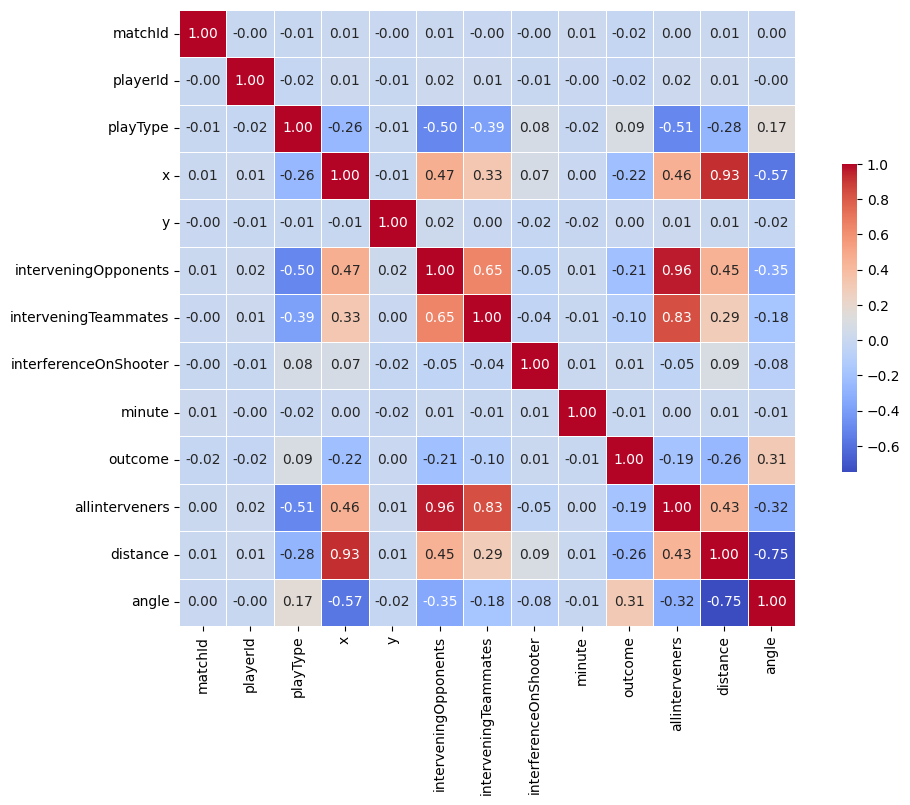

In [309]:
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])
corr_matrix = df.corr()

plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [310]:
def calculate_correlation(df, column_name):
    correlation = df[column_name].corr(df['outcome'])
    return correlation
array = []
for col in df.columns:
  correlation_result = abs(calculate_correlation(df, col))
  print(f"The correlation between {col} and the outcome is: {correlation_result}")

The correlation between matchId and the outcome is: 0.018859551447222952
The correlation between playerId and the outcome is: 0.024974188830586382
The correlation between playType and the outcome is: 0.08988260024015174
The correlation between x and the outcome is: 0.2162085535010819
The correlation between y and the outcome is: 0.0019471421947177075
The correlation between interveningOpponents and the outcome is: 0.21368034191462174
The correlation between interveningTeammates and the outcome is: 0.10116198965866115
The correlation between interferenceOnShooter and the outcome is: 0.008074569618213597
The correlation between minute and the outcome is: 0.0067264670996413254
The correlation between outcome and the outcome is: 0.9999999999999998
The correlation between allinterveners and the outcome is: 0.19205835359168708
The correlation between distance and the outcome is: 0.26073255019620584
The correlation between angle and the outcome is: 0.31316471645772026


# using a model for training using our data

In [311]:
copy = copy.dropna()
X = copy.drop('outcome', axis=1)
y = copy['outcome']

label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

y_pred_before = clf.predict(X_test)

accuracy_before = accuracy_score(y_test, y_pred_before)
print(f'Accuracy before preprocessing: {accuracy_before}')

Accuracy before preprocessing: 0.3501967397414278


In [312]:
new = df.copy()
X = new.drop('outcome', axis=1)
y = new['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

y_pred_before = clf.predict(X_test)

accuracy_before = accuracy_score(y_test, y_pred_before)
print(f'Accuracy before preprocessing: {accuracy_before}')

Accuracy before preprocessing: 0.8336143901068016


# Question 1:
Handling Missing Values: First, we used the info command to obtain the count of valid values for each column. Then, using this information, we first removed duplicate data and then addressed the empty data by removing them from the dataset.

Handling Categorical Features: For this task, we utilized Python libraries to convert columns containing categorical values into numerical values. After converting categorical values to numerical values, we proceeded with…

Feature Selection Metrics: For this, we used both Python libraries and real-world information. Based on the existing facts, we first added a set of features to our dataframe. Then, using the correlation matrix and obtaining Mutual Information, we were able to determine the relationships between variables as well as their connection to the outcome. We used this information to decide whether to add or remove features from our dataframe.

# Question 2:

در این مسئله، ما نگران این هستیم که آیا یک شوت به گل ختم خواهد شد یا نه. بنابراین، این یک متغیر دسته‌ای است. از سوی دیگر، مدل‌های رگرسیون زمانی استفاده می‌شوند که متغیر هدف پیوسته است. اگر ما در حال پیش‌بینی چیزی مانند فاصله‌ای که یک شوت طی میکند بودیم، آنگاه یک مدل رگرسیون مناسب خواهد بود.

بنابراین، در این زمینه، یک مدل دسته‌بندی مانندlogistic regression, decision tree, random forestو غیره، مناسب‌تر از یک مدل رگرسیون برای پیش‌بینی اینکه آیا یک شوت به گل ختم خواهد شد یا نه است. این مدل‌ها می‌توانند متغیرهای هدف دسته‌ای را کنترل کنند و احتمالاتی برای هر کلاس ارائه دهند، که می‌تواند برای درک و تفسیر پیش‌بینی‌های مدل بسیار مفید باشد.

# Question 3:
*Euclidian Distance:*

$ \quad \text {dis = } \sqrt {x^2 + y^2} $

*Angle (using the Law of Cosinos):*

$
\quad a^2 = b^2 + c^2 - 2bc\cos{\theta} \\
\quad \cos(\theta) = \frac{b^2 + c^2 - a^2}{2bc} \\
\quad \theta = \cos^{-1}(\cos(\theta)) \\
\quad \theta^\circ = \theta \times \frac{180}{\pi}
$



the formula inspired from this law.
Also, manual calculation of the theta based on the x and y in our dataset gives the same result as the formula above.
